# Packages

In [12]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
%run Neural_Networks.ipynb # Imports Neural Network
plt.style.use('ggplot')

# Parameters

In [13]:
# Model parameters 
mu = 0.1
sigma = 0.3
S0 = 100
K = 100
r = 0.05
T = 30/365

# Simulation parameters
steps = 30
n_train = 100000
n_test = 10000
dt = T/steps

# Neural Network parameters
epochs = 10
learn_rate = 0.001
batch_size = 100
neurons = 200 # Number of neurons in hidden layers
n_hidden_layers = 3 # Number of hidden layers
n_inputs = 2 # time and logS(t)
n_outputs = 1 # delta

In [14]:
def price_digital(S0,r,sigma,T,K):
    d2 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r-sigma**2/2)*T)
    return np.exp(-r*T)*norm.cdf(d2)
digitalprice = price_digital(S0,r,sigma,T,K)
def delta_digital(S0,r,sigma,T,K):
    d2 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r-sigma**2/2)*T)
    return np.exp(-r*T)*norm.pdf(d2)/(sigma*np.sqrt(T)*S0)

In [15]:
print(digitalprice)

0.49984781690307145


In [16]:
xi_train = npr.normal(0,np.sqrt(dt),(n_train,steps)) # Makes an (n x steps) matrix full of N(0,1/steps) realizations
W_train = np.apply_along_axis(np.cumsum,1,xi_train) # Cumulatively adds the realizations along each row
W_train = np.concatenate((np.zeros((n_train,1)),W_train),1) # Adds zeros in the first column of the matrix
drift = np.linspace(0,(mu-0.5*sigma**2)*T,steps+1) # Makes a (steps+1) length vector of equidistant values, ranging from 0 to mu
drift = np.reshape(drift,(1,steps+1)) # Converts the array into a matrix (with only 1 row)
drift_train = np.repeat(drift,n_train,axis=0) # Repeats the row n times
S_train = S0 * np.exp(drift_train + sigma * W_train) # Calculates S(t) at all timesteps and paths

dS_train = np.diff(S_train,1,1) # Calculates the change in S between each time point
time_grid = np.linspace(0,T,steps+1) # Time array

In [17]:
input_train = []
for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_train)
    time_rep = np.reshape(time_rep,(n_train,1))
    logS_train = np.reshape(np.log(S_train[:,i])-np.log(S0),(n_train,1))
    input_train.append(np.concatenate((time_rep,logS_train),1))

In [18]:
# 3 terms: Price of a call option, the value of the hedge portfolio, the payoff of the call option
def value_pf(y_true,y_pred):
    S = S0
    Vpf = digitalprice
    B = Vpf - y_pred[:,0]*S
    for i in range(1,steps):
        S += y_true[:,i-1]
        Vpf = y_pred[:,i-1]*S+B*kb.exp(r*dt)
        B = Vpf - y_pred[:,i]*S
    S += y_true[:,-1]
    Vpf = y_pred[:,-1]*S+B*kb.exp(r*dt)
    return Vpf
        
def loss_digital(y_true,y_pred):
    S_T = S0 + kb.sum(y_true,axis=-1)
    payoff = kb.maximum(S_T-K,0)/(S_T-K)
    return (value_pf(y_true,y_pred) - payoff)**2

In [19]:
model = FFNN('linear',n_inputs,n_outputs,loss_digital, learn_rate,neurons,n_hidden_layers)

In [20]:
model.fit(input_train,dS_train,batch_size=batch_size,epochs=epochs)
#model.save('BS Digital')
#model = tf.keras.models.load_model('BS Digital', compile=False)

Epoch 1/10
1000/1000 [==============================] - 59s 54ms/step - loss: 0.0340
Epoch 2/10
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0307
Epoch 3/10
1000/1000 [==============================] - 53s 53ms/step - loss: 0.0300
Epoch 4/10
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0300
Epoch 5/10
1000/1000 [==============================] - 53s 53ms/step - loss: 0.0294
Epoch 6/10
1000/1000 [==============================] - 53s 53ms/step - loss: 0.0295
Epoch 7/10
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0296
Epoch 8/10
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0294
Epoch 9/10
1000/1000 [==============================] - 53s 53ms/step - loss: 0.0292
Epoch 10/10
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0292


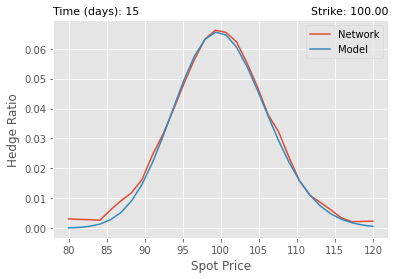

In [25]:
time_plot = 0.5*T
time_plot_days = time_plot*365
input_plot = []
# Number of times to "upscale" the plot. I.e., if steps = 30 and u want 300 points on the plot, use upscale = 10
upscale = 10

delta_NN = np.empty(upscale*steps)
S_grid = np.linspace(0.8*S0,1.2*S0, steps*upscale)

for i in range(upscale):
    input_plot = []
    for j in range(steps):
        z = (time_plot,np.log(S_grid[i*steps+j])-np.log(S0))
        z = np.reshape(z,(1,2))
        input_plot.append(z)
    delta_NN[i*steps:(i+1)*steps] = np.reshape(model.predict(input_plot),(steps,))

    
delta_BS = delta_digital(S_grid,r,sigma,T-time_plot,K)
plt.figure(figsize=(6,4))
line_NN = plt.plot(S_grid,delta_NN,label="Network")
line_BS = plt.plot(S_grid,delta_BS, label="Model")
plt.xlabel("Spot Price")
plt.ylabel("Hedge Ratio")
plt.title(r'Time (days): %1.0f' % time_plot_days, loc='left', fontsize=11)
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.legend()
#plt.show()
#plt.savefig("digital_delta.png", dpi=500,bbox_inches="tight")

# Test

In [26]:
xi_test = npr.normal(0,np.sqrt(dt),(n_test,steps)) # Makes an (n x steps) matrix full of N(0,1/steps) realizations
W_test = np.apply_along_axis(np.cumsum,1,xi_test) # Cumulatively adds the realizations along each row
W_test = np.concatenate((np.zeros((n_test,1)),W_test),1) # Adds zeros in the first column of the matrix
drift = np.linspace(0,(mu-0.5*sigma**2)*T,steps+1) # Makes a (steps+1) length vector of equidistant values, ranging from 0 to mu
drift = np.reshape(drift,(1,steps+1)) # Converts the array into a matrix (with only 1 row)
drift_test = np.repeat(drift,n_test,axis=0) # Repeats the row n times
S_test = S0 * np.exp(drift_test + sigma * W_test) # Calculates S(t) at all timesteps and paths

dS_test = np.diff(S_test,1,1) # Calculates the change in S between each time point

In [27]:
input_test = []
for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_test)
    time_rep = np.reshape(time_rep,(n_test,1))
    logS_test = np.reshape(np.log(S_test[:,i])-np.log(S0),(n_test,1))
    input_test.append(np.concatenate((time_rep,logS_test),1))

In [28]:
delta_NN_test = model.predict(input_test)
Vpf_NN = digitalprice
b = Vpf_NN - delta_NN_test[:,0]*S0
for i in range(1,steps):
    Vpf_NN = delta_NN_test[:,i-1]*S_test[:,i]+b*np.exp(r*dt)
    b = Vpf_NN - delta_NN_test[:,i]*S_test[:,i]
Vpf_NN = delta_NN_test[:,-1]*S_test[:,-1]+b*np.exp(r*dt)
Vpf_NN = np.array(Vpf_NN)

In [29]:
payoff_digital = 1*(S_test[:,-1]>K)

In [30]:
PnL_NN = Vpf_NN - payoff_digital
MSE_NN = np.sum(PnL_NN**2)/n_test

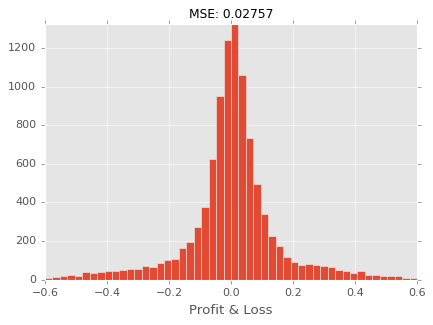

In [31]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(6,4))
    plt.hist(PnL_NN, bins=50, range=(-0.6,0.6))
    plt.title(r'MSE: %1.5f' % MSE_NN, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
plt.show()
#plt.savefig("BS_PnL_digital_NN.png", dpi=500,bbox_inches="tight")

# Comparison to hedging using BS delta

In [32]:
delta_digital_test = []
Vpf_m = digitalprice
a = delta_digital(S0, r, sigma, T, K)
b = Vpf_m - a*S0
for i in range(1,steps):
    Vpf_m = a*S_test[:,i]+b*np.exp(r*dt)
    a = delta_digital(S_test[:,i],r,sigma,T-i*dt,K)
    b = Vpf_m - a*S_test[:,i]
Vpf_m = a*S_test[:,-1]+b*np.exp(r*dt) 

In [33]:
PnL_m = Vpf_m - payoff_digital
MSE_m = np.sum(PnL_m**2)/n_test

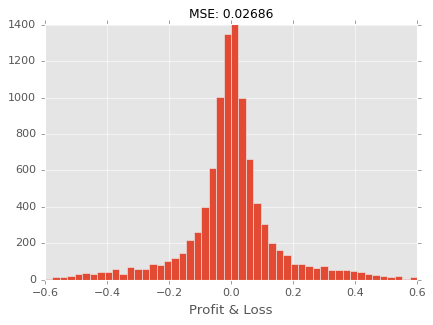

In [34]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(6,4))
    plt.hist(PnL_m, bins=50, range=(-0.6,0.6))
    plt.title(r'MSE: %1.5f' % MSE_m, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
plt.show()
#plt.savefig("BS_PnL_digital_NN.png", dpi=500,bbox_inches="tight")

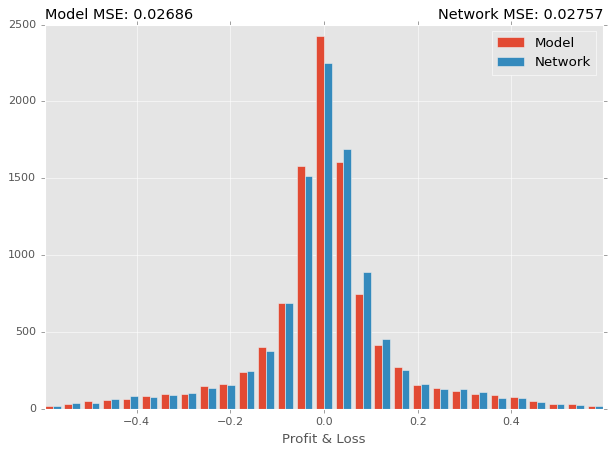

In [38]:
with plt.style.context(['classic','ggplot']):
    plt.figure(figsize=(9,6))
    bins = np.linspace(-0.6, 0.6, 30)
    plt.hist([PnL_m, PnL_NN], bins, label=['Model', 'Network'])
    plt.legend(loc='upper right')
    plt.xlabel("Profit & Loss")
    plt.title(r'Model MSE: %1.5f' % MSE_m, loc='left', fontsize=13)
    plt.title(r'Network MSE: %1.5f' % MSE_NN, loc='right', fontsize=13)
    plt.ylim(0, 2500)
#plt.show()
plt.savefig('digital_PnL.png',dpi=500,bbox_inches="tight")